# MNIST avec cVAE-GAN
## Génération d'images de chiffres écrits à la main
cVAE-GAN: AutoEncodeur Variationnel Conditionné - Réseaux Génératifs Adversariaux

Explication des termes:
- **autoencodeur**: ...
- **variationnel**: au lieu de produire directeur un vecteur, l'encodeur prédit les paramètres d'une loi de probabilité (ici loi normale). ajouter cette étape permet de s'assurer de la compatibilité entre l'entraînement et la génération (où on tire des vecteurs aléatoires) et améliore la cohérence.
- **conditionné**: au lieu de sampler depuis une distribution de probabilités globale, celle-ci est conditionnée par des variables externes (ici le chiffre qu'on veut générer). c'est ce qui permet de contrôler la génération.
- **GAN**: combinaison générateur/discriminant, le premier génére des images, l'autre essaye de trouver si elles sont réelles ou non. Ce système permet d'améliorer le réalisme et la qualité des images.

Note: Si vous ne voulez pas perdre trop de temps à entraîner les modèles, vous avez le code pour les charger directement à la fin du notebook

In [1]:
# Chargement des bibliothèques

import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# torch, torchvision: deep learning
# matplotlib: visualisation
# tqdm: barres de progression

C:\Users\Charles\AppData\Local\Temp\ipykernel_13068\4194888673.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Définition des paramètres
batch_size = 128
lr_c = 1e-3
lr_g = 1e-4
lr_d = 1e-4
l2 = 1e-4

### Préparation des données

In [3]:
# Le données sont fournies dans un format spécifique,
# il faut les transformer en tenseurs pour les utiliser
transform = transforms.Compose([
    transforms.ToTensor()
])

# On charge les données d'entraînement et de test
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# On crée des DataLoader pour itérer sur les données par batch
# La taille du batch défini le nombre d'images que l'on va traiter en même temps
# L'équilibre est important pour permettre la convergence de l'entraînement

# Une taille de batch trop élevée peut rendre l'entraînement "trop stable" et empêcher l'apprentissage
# Car on ne pourra pas sortir de minimum locaux (et augmente l'utilisation de la mémoire)

# Une taille de batch trop faible peut rendre l'entraînement instable,
# Car les gradients seront calculés sur peu d'exemples et seront donc moins précis
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# On utilise la carte graphique si elle est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Pré-Entraînement d'un réseau de classification
(servira à vérifier que les images générées appartienent bien à la classe demandée)

In [4]:
# Tous les réseaux de neurones sont des classes héritant de torch.nn.Module
# On doit donc définir une classe pour notre réseau

class MNISTClassifier(nn.Module):
    """Un petit réseau convolutif pour classifier MNIST en 10 classes."""
    def __init__(self, num_classes=10):
        super().__init__()

        # "Sequential" définie une séquence de couches
        # Chaque couche est appliquée à la sortie de la précédente
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # -> [32, 28, 28]
            nn.ReLU(True),
            nn.MaxPool2d(2),                                        # -> [32, 14, 14]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> [64, 14, 14]
            nn.ReLU(True),
            nn.MaxPool2d(2),                                        # -> [64, 7, 7]

            nn.Flatten(),                                           # -> [64*7*7]
            nn.Linear(64 * 7 * 7, num_classes)                      # -> [num_classes]
        )

        # Les deux premiers arguments de nn.Conv2d sont le nombre de canaux ou caractéristiques en entrée et en sortie
        # Ici, on a en entrée 1 canal (niveaux de gris) et en sortie 32 canaux (caractéristiques apprises)
        
        # ReLU est notre fonction d'activation non-linéaire
        # Elle remplace les valeurs négatives par zéro
        # Cela permet au réseau d'apprendre des fonctions non-linéaires

        # MaxPool2d réduit la taille de l'image en prenant le maximum sur des fenêtres de 2x2
        # Cela permet de savoir si les caractéristiques apprises sont présentes dans une région de l'image
        # On réduit seulement la précision spatiale, parce que ce n'est pas essentiel pour la classification

        # nn.Linear est une couche linéaire qui va "résumer" toutes nos informations pour effectuer la classification

    def forward(self, x):
        # x: [batch, 1, 28, 28] -> [batch, nombre de canaux, hauteur, largeur]
        return self.main(x)

In [5]:
# On prépare le réseau pour l'entraînement
classifier = MNISTClassifier(num_classes=10).to(device)

# Algorithme pour appliquer la descente de gradient
optimizer_cls = torch.optim.AdamW(classifier.parameters(), lr=lr_c, weight_decay=l2)

# Fonction de coût à minimiser pendant l'entraînement
criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)

In [6]:
# Boucle d'entraînement
num_epoch = 5

for epoch in range(num_epoch):
    classifier.train()
    loss_epoch = 0.0
    accuracy_epoch = 0.0

    for imgs, labels in tqdm(train_loader): # On itère sur chaque batch de 128 images
        imgs = imgs.to(device)
        labels = labels.to(device)

        # On calcule la fonction de coût
        outputs = classifier(imgs)
        loss = criterion_cls(outputs, labels)

        accuracy = (outputs.argmax(dim=1) == labels).float().mean()

        # On calcule les gradients et on met à jour les poids du réseau
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        loss_epoch += loss.item()
        accuracy_epoch += accuracy.item()

    loss_epoch /= len(train_loader)
    accuracy_epoch /= len(train_loader)
    print(f"[Classifier] Epoch {epoch+1}/{num_epoch} loss: {loss_epoch:.4f} accuracy: {accuracy_epoch:.4f}")

  0%|          | 0/469 [00:00<?, ?it/s]

[Classifier] Epoch 1/5 loss: 0.7511 accuracy: 0.9321


  0%|          | 0/469 [00:00<?, ?it/s]

[Classifier] Epoch 2/5 loss: 0.6015 accuracy: 0.9832


  0%|          | 0/469 [00:00<?, ?it/s]

[Classifier] Epoch 3/5 loss: 0.5837 accuracy: 0.9874


  0%|          | 0/469 [00:00<?, ?it/s]

[Classifier] Epoch 4/5 loss: 0.5720 accuracy: 0.9900


  0%|          | 0/469 [00:00<?, ?it/s]

[Classifier] Epoch 5/5 loss: 0.5654 accuracy: 0.9920


In [7]:
# Test de précision sur le jeu de test
classifier.eval()
correct = 0
total = 0

# On indique à Pytorch de ne pas calculer les gradients
# Cela permet de gagner du temps et de la mémoire
# Par défaut, Pytorch garde la trace de tous les calculs effectués
# Afin de pouvoir calculer les gradients pour la rétropropagation
with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = classifier(imgs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

acc = 100.0 * correct / total
print(f"Classifier accuracy on test set: {acc:.2f}%")

  0%|          | 0/79 [00:00<?, ?it/s]

Classifier accuracy on test set: 99.03%


In [6]:
# On fige le classifier pour ne plus modifier ses poids
classifier.eval()

for param in classifier.parameters():
    param.requires_grad = False

### Entraînement du réseau principal

In [7]:
class CVAEGenerator(nn.Module):
    """Générateur (cVAE) = Encodeur + Décodeur conditionnel."""
    def __init__(self, latent_dim=16, label_embed_dim=16, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.label_embed_dim = label_embed_dim
        self.num_classes = num_classes

        # L'embedding est un dictionnaire qui associe chaque classe à un vecteur de dimension label_embed_dim
        # Cela permet au réseau d'apprendre un vecteur spécifique pour décrire chaque classe
        # Au lieu, par exemple, d'un simple vecteur [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] pour la classe 9
        self.label_embedding = nn.Embedding(num_classes, label_embed_dim)

        # Encodeur (voir classifier pour les détails)
        in_channels = 1 + label_embed_dim
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.enc_flat_dim = 64 * 7 * 7

        # Ici, on prédira la moyenne et la log-variance de la distribution normale latente
        # On utilise la log-variance pour des raisons de stabilité numérique
        self.fc_mu = nn.Linear(self.enc_flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_flat_dim, latent_dim)

        # Décodeur
        decoder_in_dim = latent_dim + label_embed_dim
        self.fc_decode = nn.Linear(decoder_in_dim, self.enc_flat_dim)
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        # La convolution transposée est l'opération inverse de la convolution
        # Elle permet de passer d'une image de petite taille à une image de grande taille


    # Tout se qui se trouve ici n'est pas essentiel à comprendre pour l'instant
    # C'est la définition des opérations effectuées par le réseau
    def encode(self, x, labels):
        emb = self.label_embedding(labels)
        emb_2d = emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))
        x_enc = torch.cat([x, emb_2d], dim=1)
        h = self.encoder_conv(x_enc)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        emb = self.label_embedding(labels)
        zc = torch.cat([z, emb], dim=1)
        h = self.fc_decode(zc)
        h = h.view(h.size(0), 64, 7, 7)
        x_recon = self.decoder_deconv(h)
        return x_recon

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z, labels)
        return x_reconst, mu, logvar

In [8]:
class ConditionalDiscriminator(nn.Module):
    """Discriminateur conditionnel."""
    def __init__(self, label_embed_dim=16, num_classes=10):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, label_embed_dim)
        in_channels = 1 + label_embed_dim

        self.main = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(64*7*7, 1)
        )

        # LeakyReLU est une variante de ReLU qui permet de conserver un gradient non-nul pour les valeurs négatives
        # Cela permet d'éviter que le réseau ne "meurt" en ne transmettant plus d'information
        # Ici, on l'utilise pour le discriminateur, car il peut être plus difficile à entraîner

    def forward(self, x, labels):
        emb = self.label_embedding(labels)
        emb_2d = emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))
        x_disc = torch.cat([x, emb_2d], dim=1)
        out = self.main(x_disc)
        return out

In [9]:
# Fonctions de pertes
def vae_reconstruction_loss(x_recon, x):
    """Calcul la différence entre l'image originale et l'image reconstruite."""
    return F.binary_cross_entropy(x_recon, x, reduction='mean')

def vae_kl_divergence(mu, logvar):
    """Calcul la divergence KL entre la distribution latente et une normale."""
    return 0.5 * torch.mean(mu**2 + torch.exp(logvar) - logvar - 1)

bce_loss = nn.BCEWithLogitsLoss()   # Perte de classification binaire (vrai/faux) utilisée pour le discriminateur

# On réutilisera aussi la perte de classification définie plus haut pour le classifier

# Pondération des différentes pertes:
# Puisque chaque perte a une échelle différente, on peut les pondérer pour les équilibrer
# Cela permet d'éviter que le réseau ne se concentre que sur une perte à minimiser
lambda_recon = 50.0
lambda_kl    = 20.0
lambda_adv   = 1.0
lambda_cls   = 100.0

In [10]:
# On crée les réseaux
G = CVAEGenerator(latent_dim=20, label_embed_dim=16).to(device)
D = ConditionalDiscriminator(label_embed_dim=16).to(device)

# On crée les optimiseurs
optimizer_G = torch.optim.AdamW(G.parameters(), lr=lr_g, weight_decay=l2)
optimizer_D = torch.optim.AdamW(D.parameters(), lr=lr_d, weight_decay=l2)

In [28]:
# Boucle d'entraînement
num_epochs = 10

for epoch in range(num_epochs):
    loss_recon = 0.0
    loss_kl    = 0.0
    loss_adv   = 0.0
    loss_cls   = 0.0

    accuracy_discriminator = 0.0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # ------------------------------
        # 1) Discriminateur
        # ------------------------------
        D.train()
        optimizer_D.zero_grad()

        # (a) Vrai
        real_logits = D(images, labels)
        real_targets = torch.ones(images.size(0), 1, device=device)
        loss_D_real = bce_loss(real_logits, real_targets)

        # (b) Faux (générés)
        with torch.no_grad():
            z = torch.randn(images.size(0), G.latent_dim, device=device)
            fake_images = G.decode(z, labels)

        fake_logits = D(fake_images, labels)
        fake_targets = torch.zeros(images.size(0), 1, device=device)
        loss_D_fake = bce_loss(fake_logits, fake_targets)

        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        loss_D.backward()
        optimizer_D.step()

        predictions = (torch.sigmoid(real_logits) > 0.5).float()
        accuracy_discriminator += (predictions == real_targets).float().mean()

        # ------------------------------
        # 2) Générateur
        # ------------------------------
        G.train()
        optimizer_G.zero_grad()

        # (a) Reconstruction
        x_recon, mu, logvar = G(images, labels)
        recon_loss = vae_reconstruction_loss(x_recon, images)
        kl_loss    = vae_kl_divergence(mu, logvar)

        # (b) Adversarial
        z = torch.randn(images.size(0), G.latent_dim, device=device)
        fake_for_G = G.decode(z, labels)
        fake_logits_for_G = D(fake_for_G, labels)
        adv_targets = torch.ones(images.size(0), 1, device=device)
        adv_loss = bce_loss(fake_logits_for_G, adv_targets)

        # (c) Classification
        with torch.no_grad():
            cls_outputs = classifier(fake_for_G)
        
        loss_cls = criterion_cls(cls_outputs, labels)

        # (d) Total
        loss_G = (lambda_recon * recon_loss
                  + lambda_kl * kl_loss
                  + lambda_adv * adv_loss
                  + lambda_cls * loss_cls)

        loss_G.backward()
        nn.utils.clip_grad_norm_(G.parameters(), 1.0)
        optimizer_G.step()

        loss_recon += recon_loss.item()
        loss_kl    += kl_loss.item()
        loss_adv   += adv_loss.item()
        loss_cls   += loss_cls.item()

    epoch_loss_recon = loss_recon / len(train_loader)
    epoch_loss_kl    = loss_kl / len(train_loader)
    epoch_loss_adv   = loss_adv / len(train_loader)
    epoch_loss_cls   = loss_cls / len(train_loader)

    accuracy_discriminator /= len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} terminé.")
    print(f"  Recon Loss: {(lambda_recon * epoch_loss_recon):.4f}")
    print(f"  KL Loss: {(lambda_kl * epoch_loss_kl):.4f}")
    print(f"  Adv Loss: {(lambda_adv * epoch_loss_adv):.4f}")
    print(f"  Cls Loss: {(lambda_cls * epoch_loss_cls):.4f}")
    print(f"  Acc Discriminator: {accuracy_discriminator:.4f}")

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/10 terminé.
  Recon Loss: 19.5386
  KL Loss: 0.6397
  Adv Loss: 2.1007
  Cls Loss: 0.5255
  Acc Discriminator: 0.8680


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10 terminé.
  Recon Loss: 11.1033
  KL Loss: 0.3313
  Adv Loss: 0.9473
  Cls Loss: 0.4096
  Acc Discriminator: 0.8482


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10 terminé.
  Recon Loss: 11.0589
  KL Loss: 0.7532
  Adv Loss: 1.3847
  Cls Loss: 0.3563
  Acc Discriminator: 0.8974


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10 terminé.
  Recon Loss: 11.0483
  KL Loss: 1.1244
  Adv Loss: 1.5359
  Cls Loss: 0.3693
  Acc Discriminator: 0.9066


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10 terminé.
  Recon Loss: 11.0490
  KL Loss: 1.3909
  Adv Loss: 1.6363
  Cls Loss: 0.4031
  Acc Discriminator: 0.9156


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10 terminé.
  Recon Loss: 11.1898
  KL Loss: 1.5601
  Adv Loss: 1.7006
  Cls Loss: 0.3669
  Acc Discriminator: 0.9231


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10 terminé.
  Recon Loss: 11.2745
  KL Loss: 1.7266
  Adv Loss: 1.7622
  Cls Loss: 0.3776
  Acc Discriminator: 0.9129


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10 terminé.
  Recon Loss: 11.1961
  KL Loss: 1.9518
  Adv Loss: 1.8236
  Cls Loss: 0.2841
  Acc Discriminator: 0.8888


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10 terminé.
  Recon Loss: 11.0256
  KL Loss: 2.1878
  Adv Loss: 1.8456
  Cls Loss: 0.2797
  Acc Discriminator: 0.8614


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10 terminé.
  Recon Loss: 10.8589
  KL Loss: 2.3790
  Adv Loss: 1.8354
  Cls Loss: 0.2563
  Acc Discriminator: 0.8289


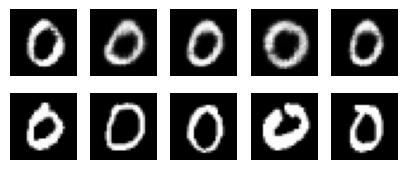

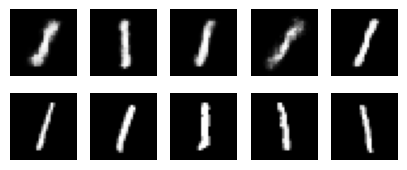

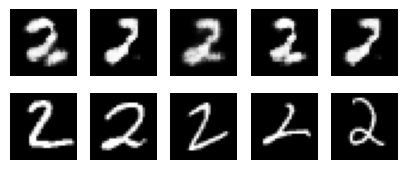

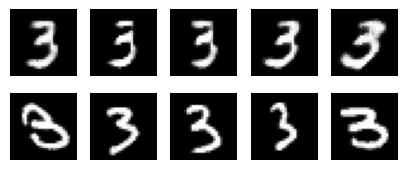

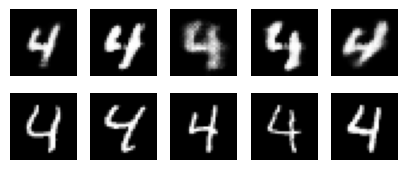

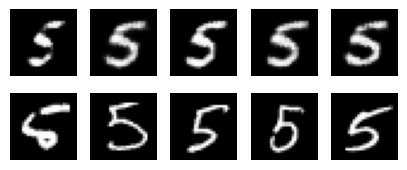

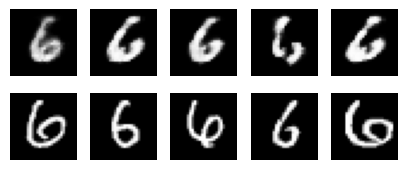

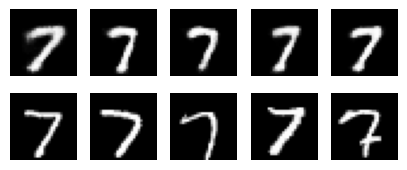

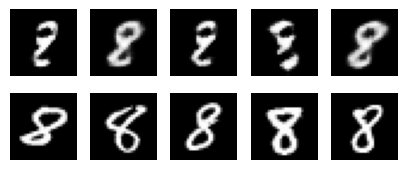

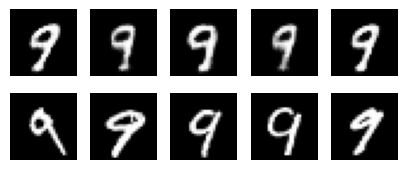

In [26]:
# Test du générateur (et comparaison avec des images réelles)

G.eval()
with torch.no_grad():
    # On génère 5 images pour chaque classe
    num_samples = 5
    for i in range(10):
        labels = torch.full((num_samples,), i, device=device, dtype=torch.long)
        # Génération de tenseurs pour le discriminateur
        samples_tensor = G.decode(torch.randn(num_samples, G.latent_dim, device=device), labels)
        quality_scores = torch.sigmoid(D(samples_tensor, labels)).cpu().numpy()

        samples = samples_tensor.cpu().numpy()

        # Récupérer des images réelles du jeu de test
        real_images = []
        count = 0
        for img, label in test_loader:
            if count >= num_samples:
                break
            for j in range(len(label)):
                if label[j] == i:
                    real_images.append(img[j].cpu().numpy())
                    count += 1
                    if count >= num_samples:
                        break

        real_images_tensor = torch.stack([torch.tensor(im) for im in real_images]).to(device)
        real_quality_scores = torch.sigmoid(D(real_images_tensor, labels)).cpu().numpy()

        # print("Synth quality scores:\n", quality_scores)
        # print()
        # print("Real quality scores:\n", real_quality_scores)

        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples, 2))
        for j in range(num_samples):
            axes[0, j].imshow(samples[j][0], cmap='gray')
            axes[0, j].axis('off')
            axes[1, j].imshow(real_images[j][0], cmap='gray')
            axes[1, j].axis('off')

        plt.show()
        plt.close(fig)


In [30]:
# Sauvegarde des modèles
torch.save(G.state_dict(), "G.pt")
torch.save(D.state_dict(), "D.pt")
torch.save(classifier.state_dict(), "classifier.pt")

In [ ]:
# Charger les modèles (pensez à exécuter les cellules qui définissent les classes avant)
G = CVAEGenerator(latent_dim=20, label_embed_dim=16).to(device)
D = ConditionalDiscriminator(label_embed_dim=16).to(device)
classifier = MNISTClassifier(num_classes=10).to(device)

G.load_state_dict(torch.load("G.pt", weights_only=True))
D.load_state_dict(torch.load("D.pt", weights_only=True))
classifier.load_state_dict(torch.load("classifier.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
# Note Perso: le classifier a pas l'air très utile, peut-être le retirer